# Costa Rican Household Poverty Level Prediction

## Imports

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import random

sns.set_theme(style="whitegrid")
sns.set_palette("crest")

In [3]:
df = pd.read_csv("data/train.csv")

## Exploratory Data Analysis

In [4]:
df.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [5]:
print("Missing data")
df.isna().sum()[lambda x: x != 0]

Missing data


v2a1         6860
v18q1        7342
rez_esc      7928
meaneduc        5
SQBmeaned       5
dtype: int64

In [6]:
int_types = ["int16", "int32", "int64"]
float_types = ["float16", "float32", "float64"]
cat_types = ["object"]

int_cols = df.select_dtypes(include=int_types).columns
float_cols = df.select_dtypes(include=float_types).columns
cat_cols = df.select_dtypes(include=cat_types).columns

In [7]:
def mean(df):
    return df.mean()

def std(df):
    return df.std()

def perc_25(df):
    return df.quantile(0.25)

def median(df):
    return df.median()

def perc_75(df):
    return df.quantile(0.75)

def kurtiosis(df):
    return df.kurtosis()

def skewness(df):
    return df.skew()

In [8]:
df.select_dtypes(include=int_types + float_types).agg(["min", "max", mean, std, perc_25, median, perc_75, kurtiosis, skewness])

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
min,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,1.000000
max,2.353477e+06,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,8.000000,...,441.000000,9409.000000,169.000000,441.000000,81.000000,36.000000,64.000000,1369.000000,9409.000000,4.000000
mean,1.652316e+05,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,1.404063,0.385895,1.559171,...,74.222769,1643.774302,19.132887,53.500262,3.844826,3.249485,3.900409,102.588867,1643.774302,3.302292
std,1.504571e+05,0.191417,1.468381,0.151957,0.072145,0.201459,0.421983,0.763131,0.680779,1.036574,...,76.777549,1741.197050,18.751395,78.445804,6.946296,4.129547,12.511831,93.516890,1741.197050,1.009565
perc_25,8.000000e+04,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,16.000000,289.000000,9.000000,0.000000,0.000000,1.000000,0.111111,36.000000,289.000000,3.000000
median,1.300000e+05,0.000000,5.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,36.000000,961.000000,16.000000,36.000000,1.000000,2.250000,0.444444,81.000000,961.000000,4.000000
perc_75,2.000000e+05,0.000000,6.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,2.000000,...,121.000000,2601.000000,25.000000,81.000000,4.000000,4.000000,1.777778,134.560010,2601.000000,4.000000
kurtiosis,3.772151e+01,21.306863,0.956625,37.331987,186.243311,18.652168,-0.383211,6.965929,6.627214,3.297986,...,1.581615,1.561409,15.546472,4.059243,36.979988,23.146871,18.137526,19.555483,1.561409,-0.255486
skewness,4.069222e+00,4.827256,0.492808,6.270899,-13.718759,-4.544036,1.271562,2.388372,2.164806,1.232271,...,1.353108,1.366840,3.225972,1.993690,4.924682,4.186951,4.404052,2.907730,1.366840,-1.092249


1: extreme poverty
2: moderate poverty
3: vulnerable households
4: non vulnerable households


/var/folders/m4/yzg21tsj3630sx61vsl4db4h0000gn/T/ipykernel_38595/2549530391.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "Target", data = df, palette = "crest")


<Axes: xlabel='Target', ylabel='count'>

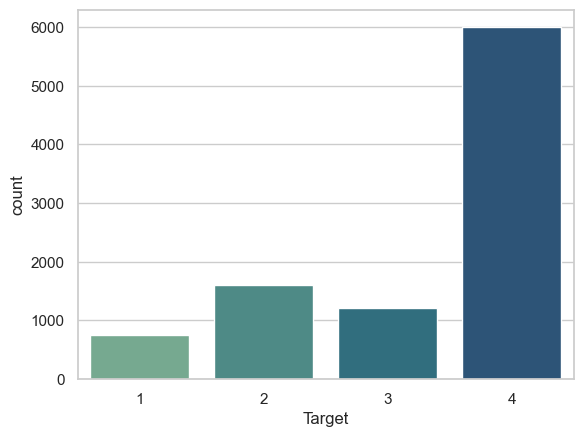

In [9]:
print("1: extreme poverty\n2: moderate poverty\n3: vulnerable households\n4: non vulnerable households")
sns.countplot(x = "Target", data = df, palette = "crest")

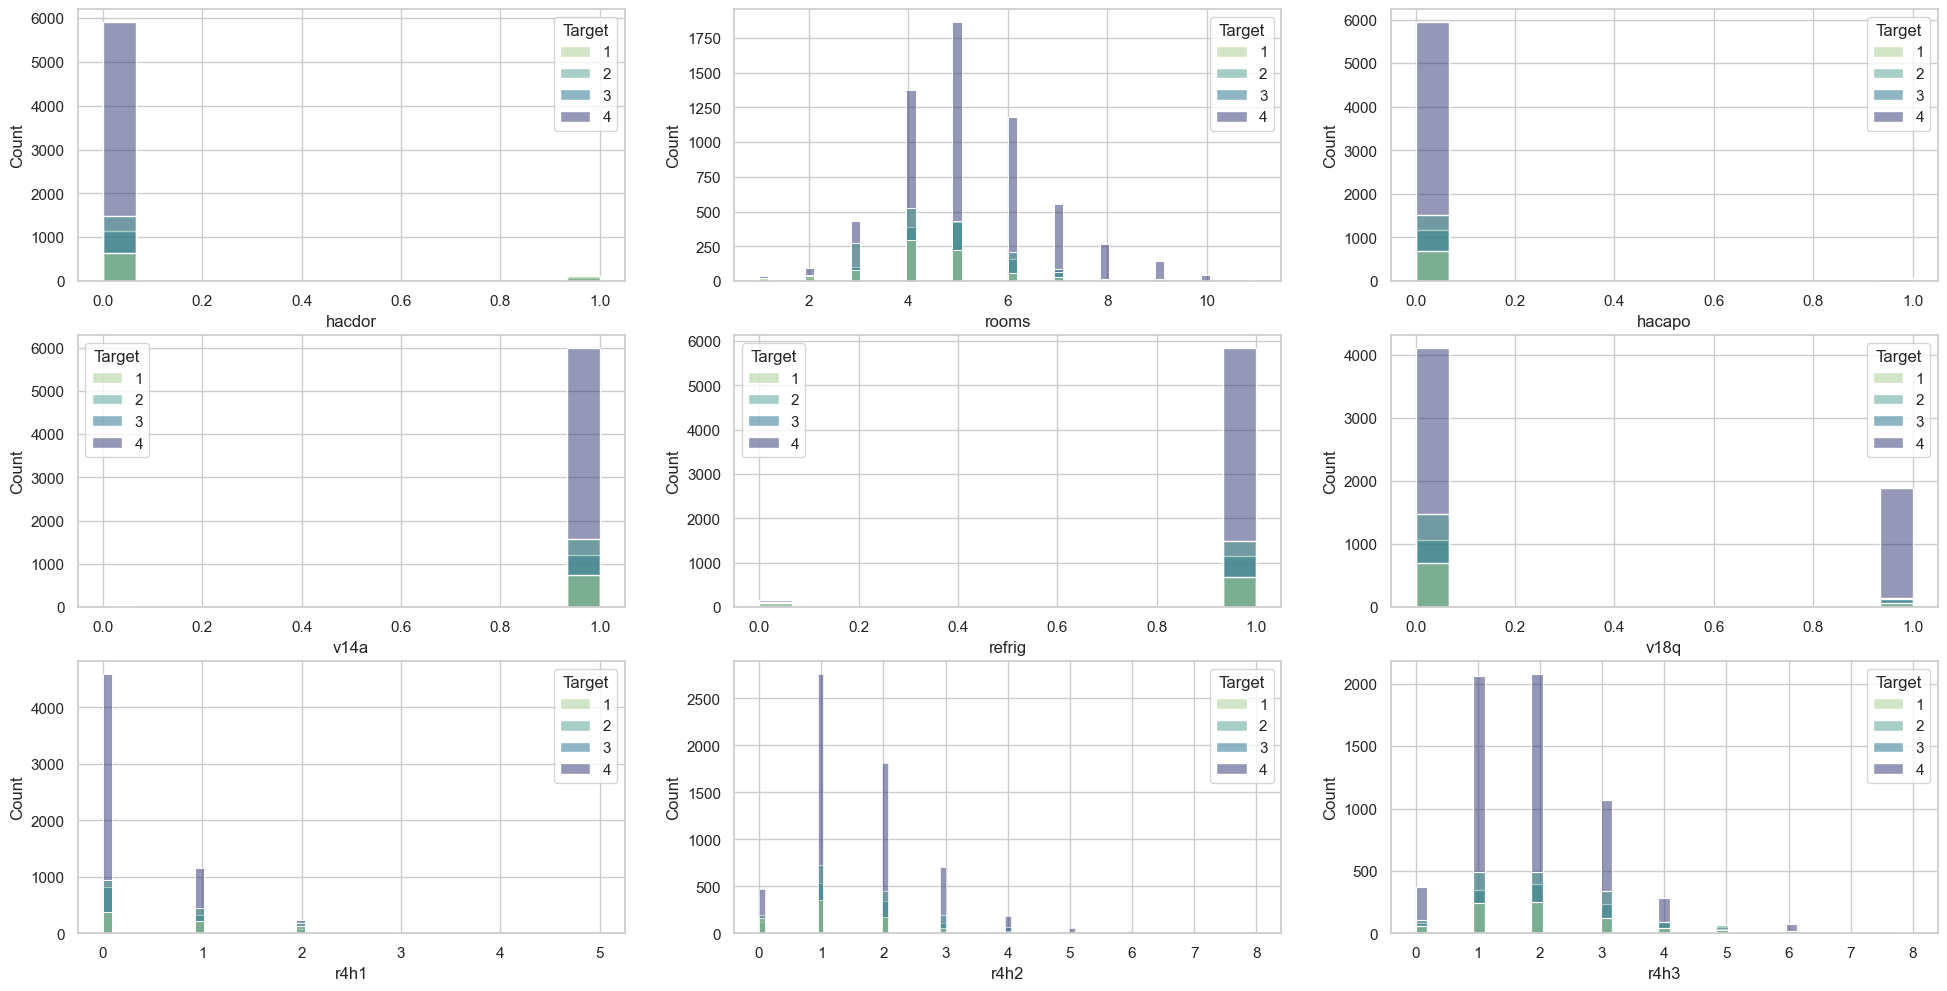

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(24, 12))
for ax, feature in zip(fig.get_axes(), int_cols):
    sns.histplot(x = feature, data = df, hue = "Target", ax = ax, palette = "crest")

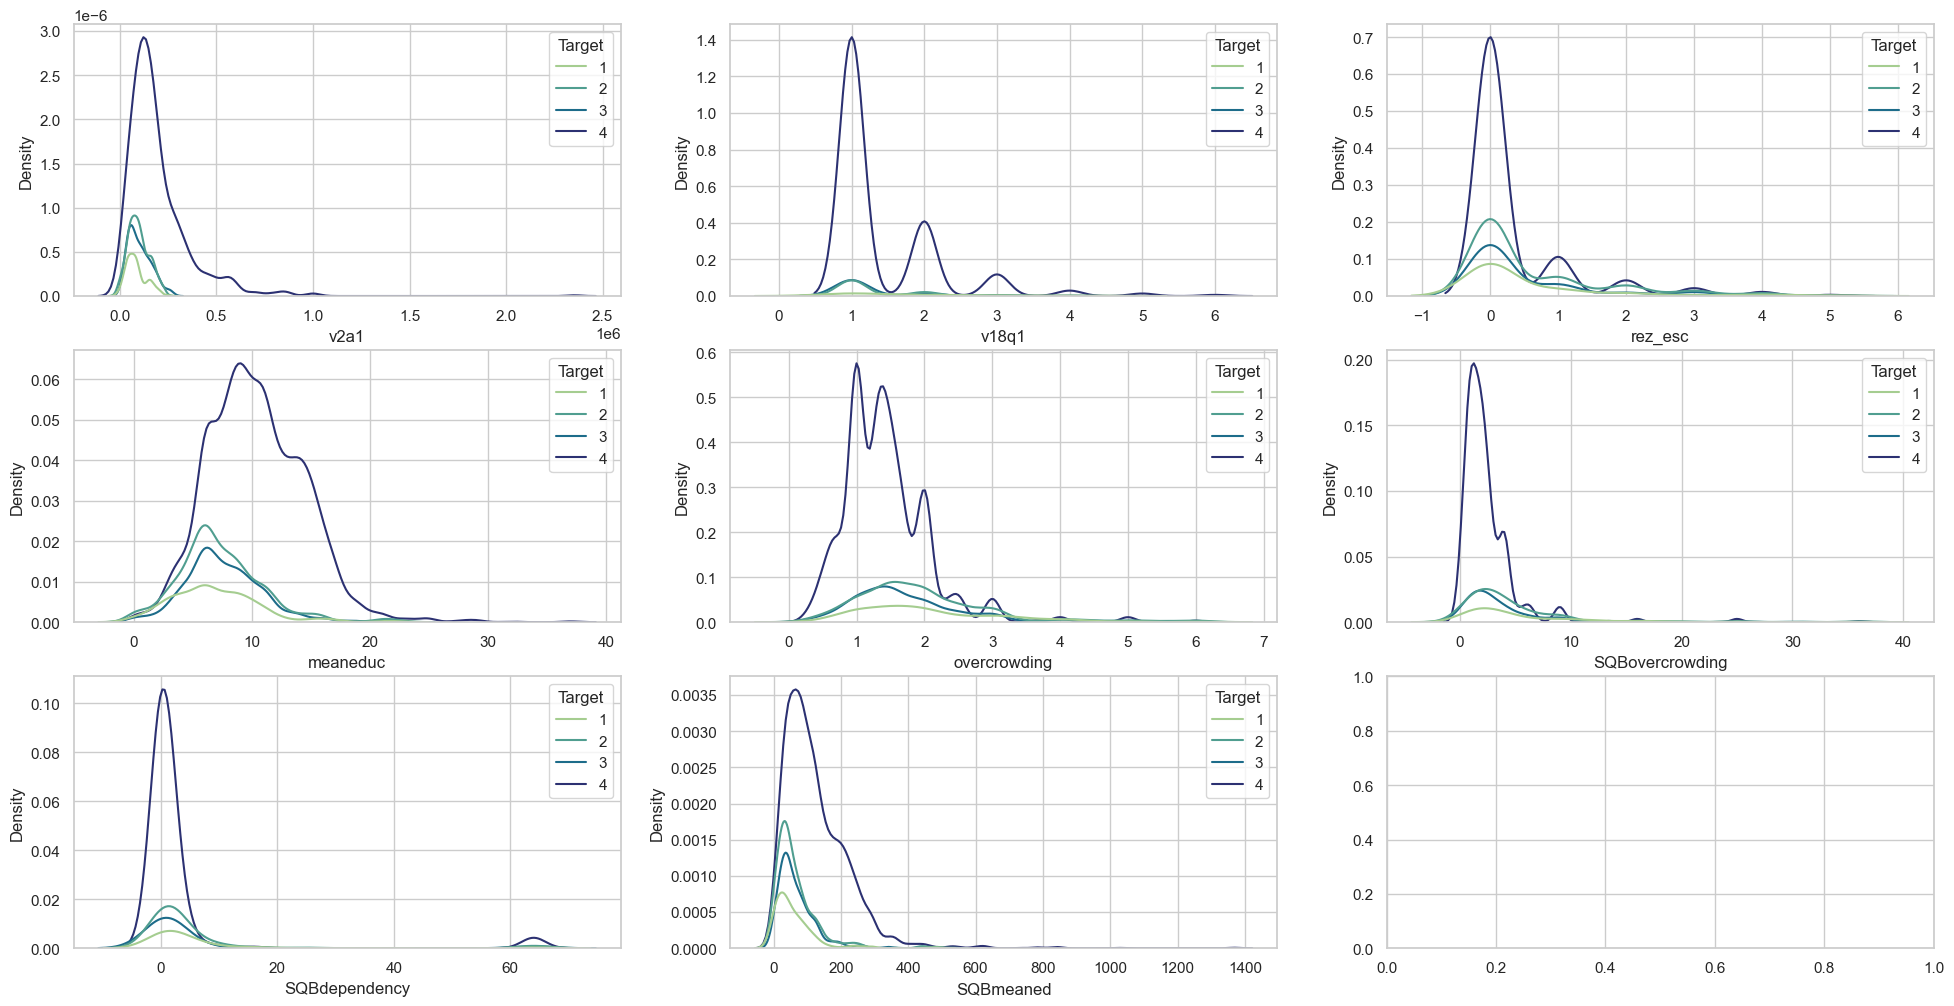

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(24, 12))
for ax, feature in zip(fig.get_axes(), float_cols):
    sns.kdeplot(x = feature, data = df, hue = "Target", ax = ax, palette = "crest")

[Text(0.5, 1.0, 'Monthly rent payment'), Text(0.5, 0, 'Rent payment')]

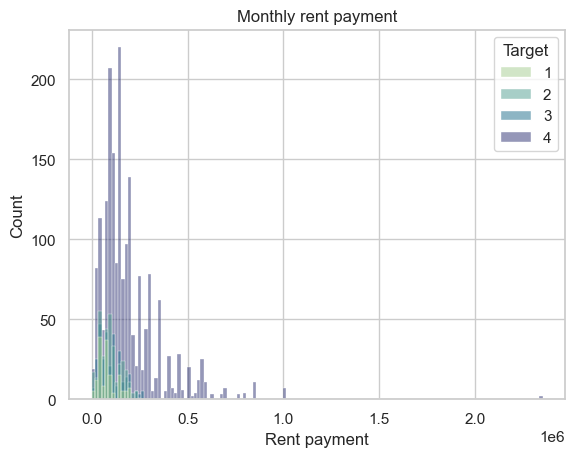

In [12]:
sns.histplot(x = "v2a1", data = df, hue = "Target", palette = "crest").set(title = "Monthly rent payment", xlabel="Rent payment")

In [13]:
# remove outliers
q = df["v2a1"].quantile(0.999)
df = df[df["v2a1"] < q]

[Text(0.5, 1.0, 'Same plot after removing outliers'),
 Text(0.5, 0, 'Rent payment')]

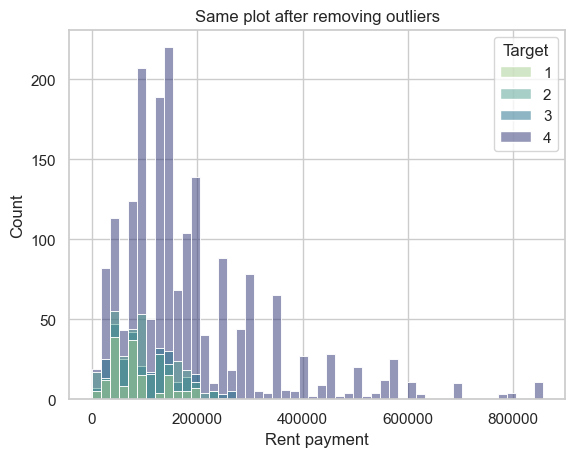

In [14]:
sns.histplot(x = "v2a1", data = df, hue = "Target", palette = "crest").set(title = "Same plot after removing outliers", xlabel="Rent payment")

[Text(0.5, 0, 'Total household size')]

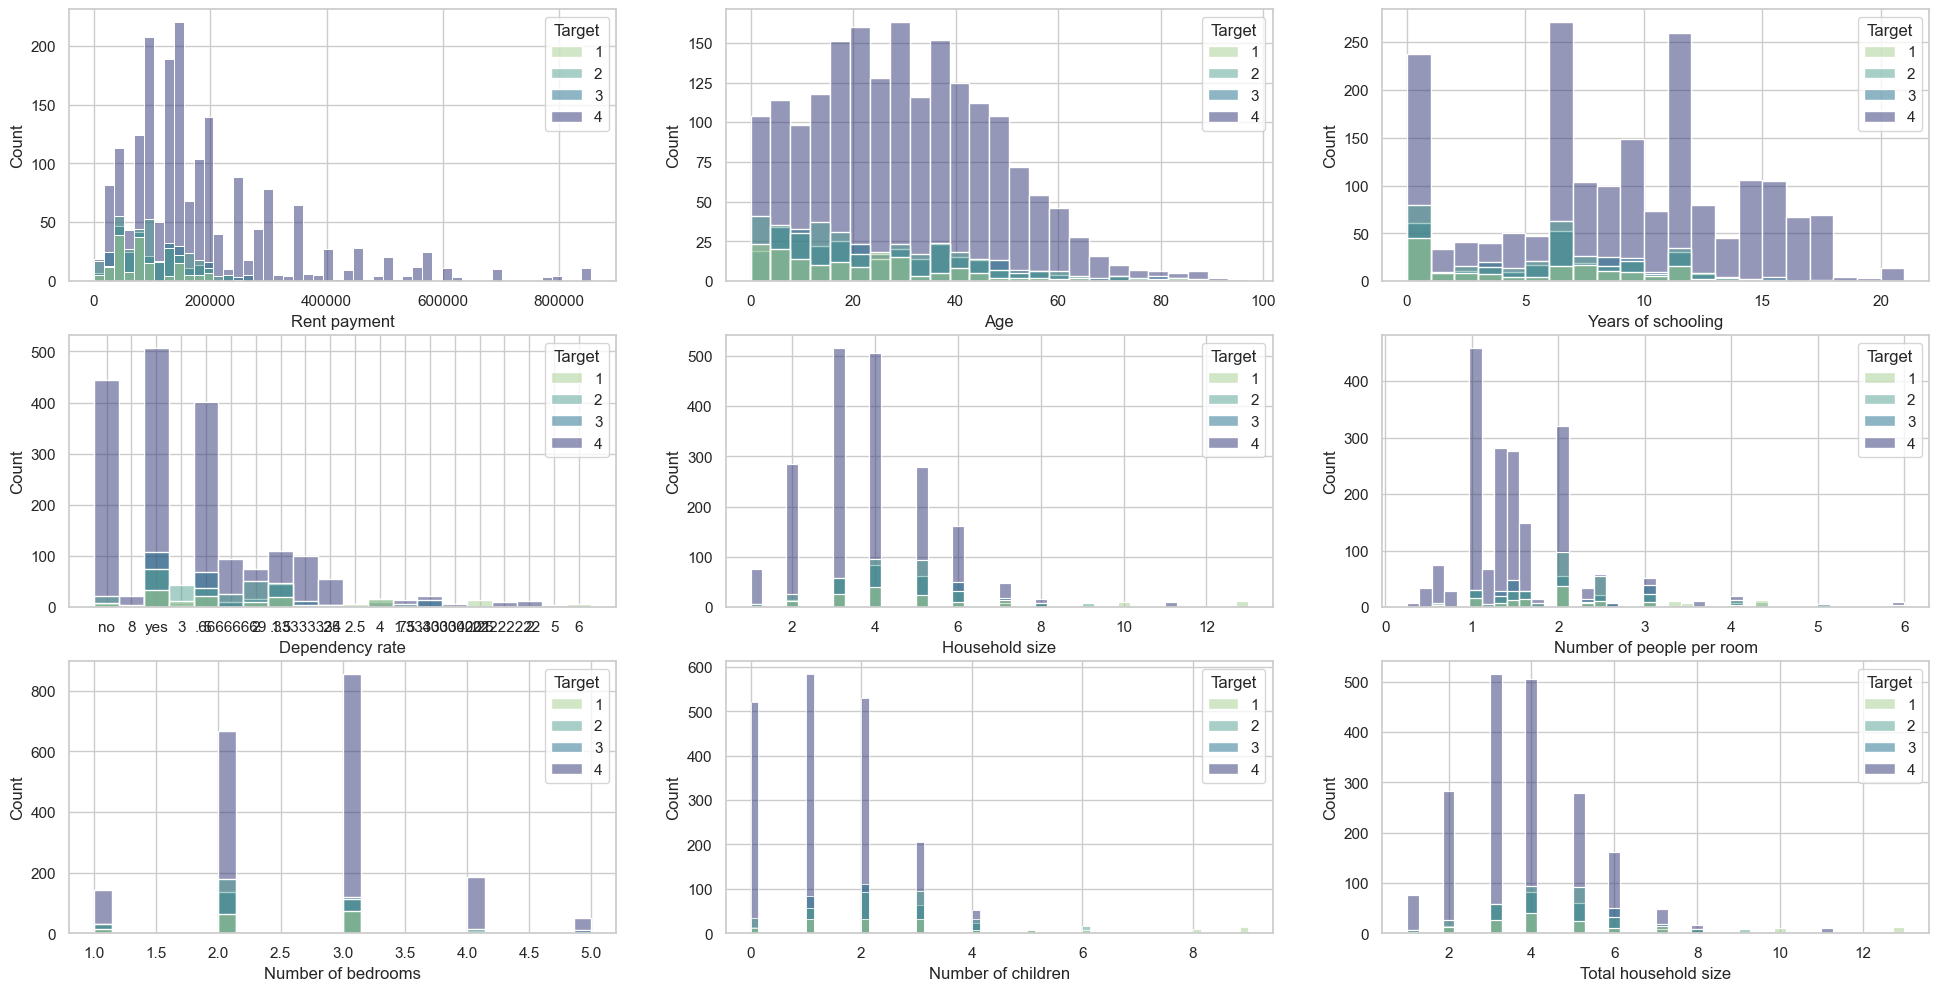

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(24, 12))
sns.histplot(x = "v2a1", data = df, hue = "Target", ax = axes[0][0], palette = "crest").set(xlabel="Rent payment")
sns.histplot(x = "age", data = df, hue="Target", ax = axes[0][1], palette = "crest").set(xlabel="Age")
sns.histplot(x = "escolari", data = df, hue="Target", ax = axes[0][2], palette = "crest").set(xlabel="Years of schooling")

sns.histplot(x = "dependency", data = df, hue="Target", ax = axes[1][0], palette = "crest").set(xlabel="Dependency rate")
sns.histplot(x = "hhsize", data = df, hue="Target", ax = axes[1][1], palette = "crest").set(xlabel="Household size")
sns.histplot(x = "overcrowding", data = df, hue="Target", ax = axes[1][2], palette = "crest").set(xlabel="Number of people per room")

sns.histplot(x = "bedrooms", data = df, hue="Target", ax = axes[2][0], palette = "crest").set(xlabel="Number of bedrooms")
sns.histplot(x = "hogar_nin", data = df, hue="Target", ax = axes[2][1], palette = "crest").set(xlabel="Number of children")
sns.histplot(x = "hogar_total", data = df, hue="Target", ax = axes[2][2], palette = "crest").set(xlabel="Total household size")

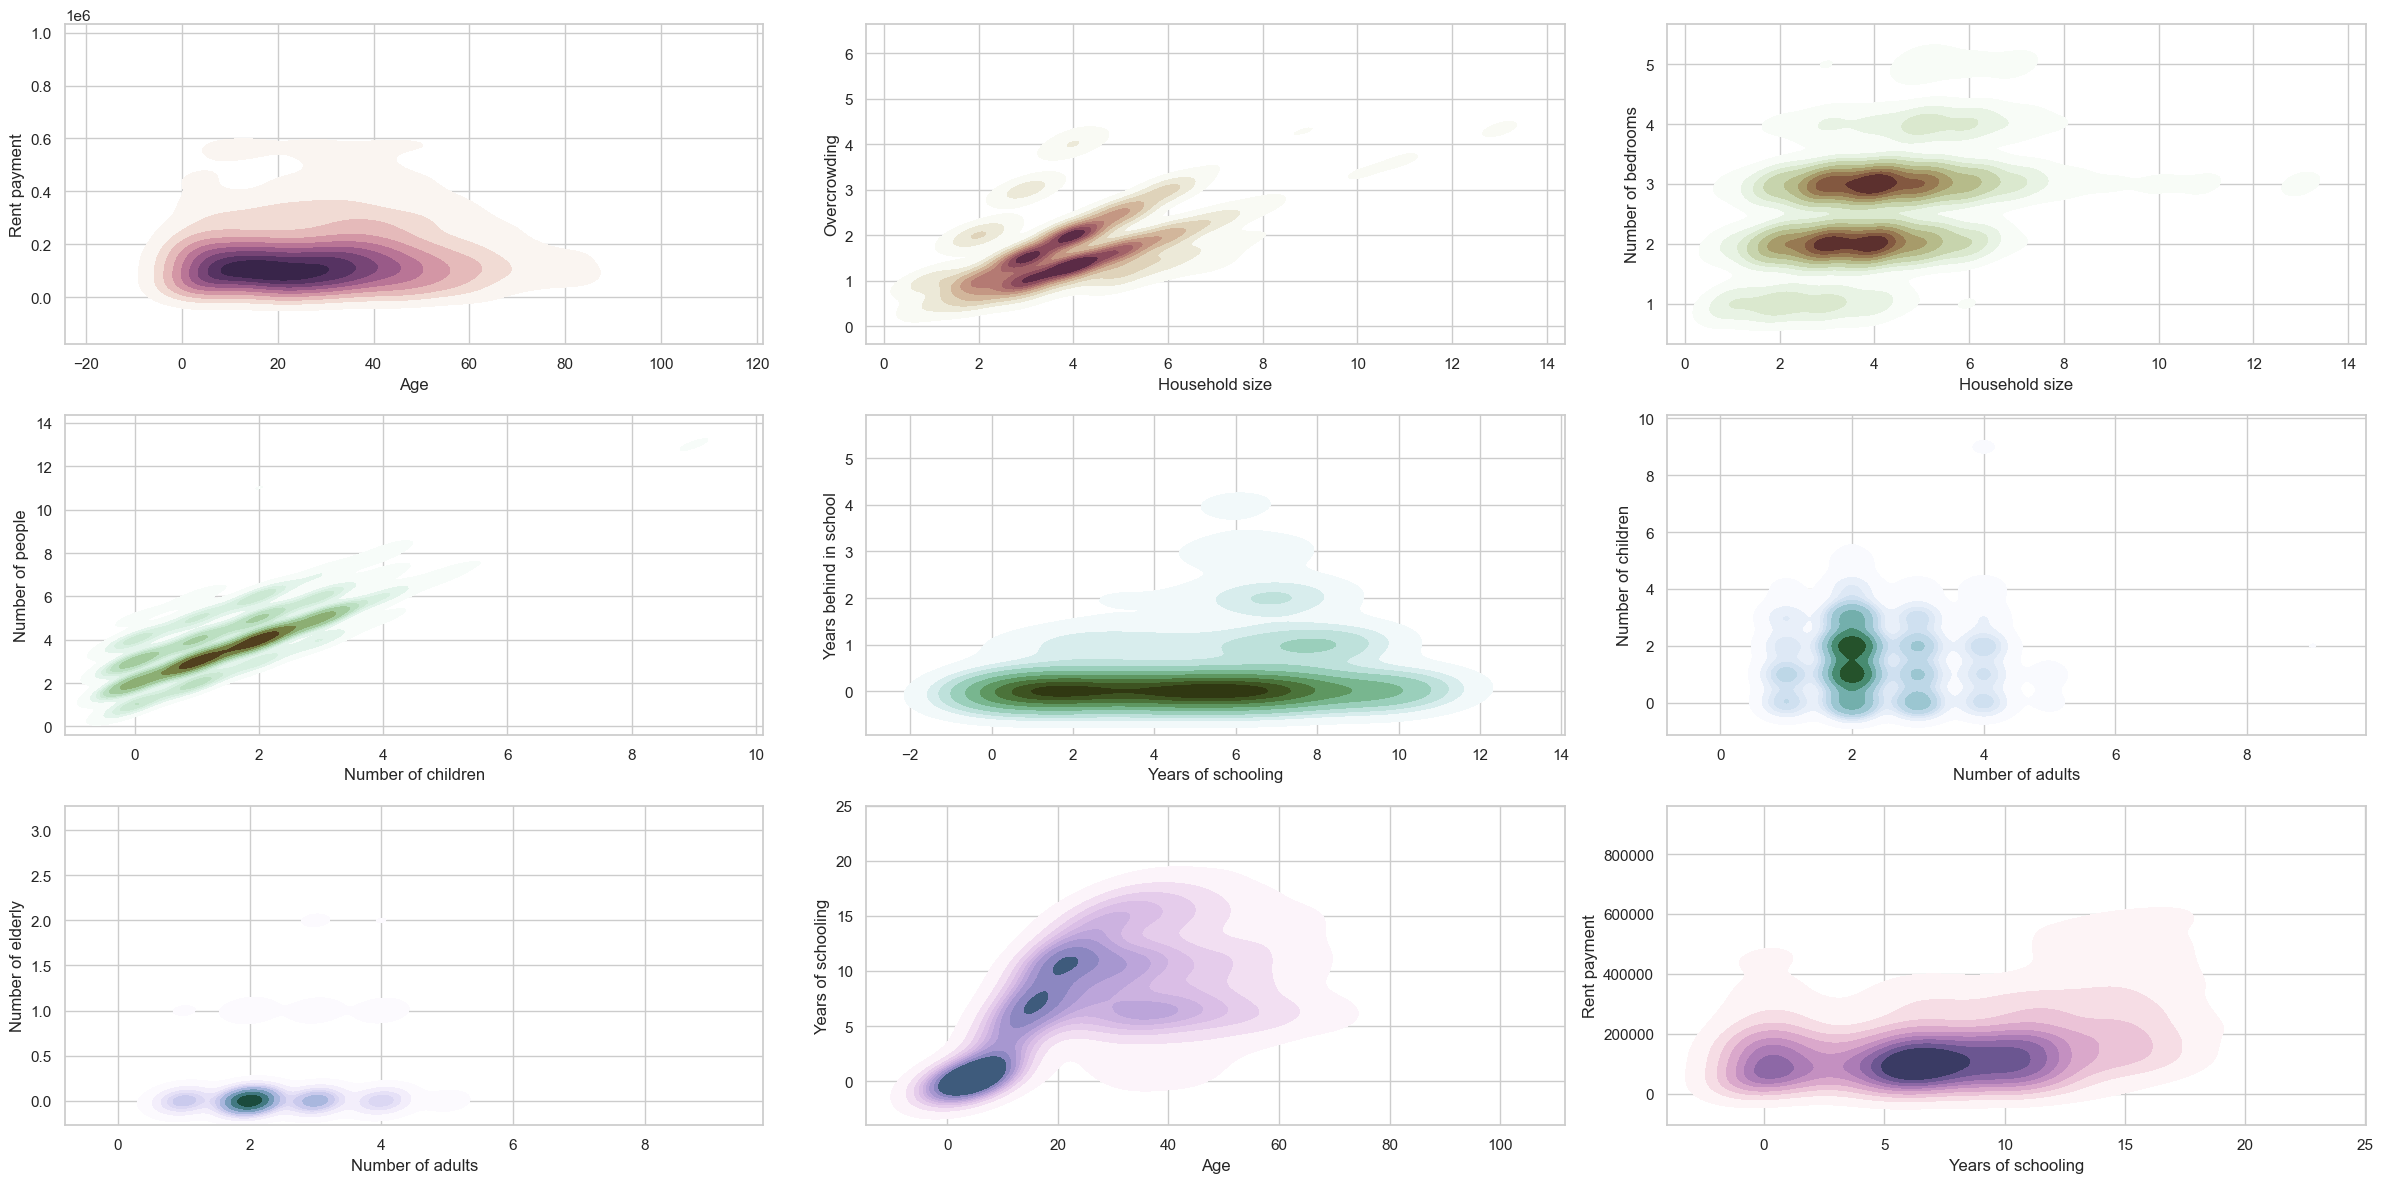

In [16]:
# Plotting the KDEplots
f, axes = plt.subplots(3, 3, figsize=(24, 12), sharex=False, sharey=False)

cmap = sns.cubehelix_palette(start=0.0, light=1, as_cmap=True)
sns.kdeplot(df, x = "age", y = "v2a1", cmap=cmap, fill=True, cut=5, ax=axes[0,0]).set(xlabel="Age", ylabel="Rent payment")
cmap = sns.cubehelix_palette(start=1/3, light=1, as_cmap=True)
sns.kdeplot(df, x="hhsize", y="overcrowding", cmap=cmap, fill=True, ax=axes[0,1]).set(xlabel="Household size", ylabel="Overcrowding")
cmap = sns.cubehelix_palette(start=2/3, light=1, as_cmap=True)
sns.kdeplot(df, x="hhsize", y="bedrooms", cmap=cmap, fill=True, ax=axes[0,2]).set(xlabel="Household size", ylabel="Number of bedrooms")

cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)
sns.kdeplot(df, x="hogar_nin", y="hogar_total", cmap=cmap, fill=True, ax=axes[1,0]).set(xlabel="Number of children", ylabel="Number of people")
cmap = sns.cubehelix_palette(start=4/3, light=1, as_cmap=True)
sns.kdeplot(df, x="escolari", y="rez_esc", cmap=cmap, fill=True, ax=axes[1,1]).set(xlabel="Years of schooling", ylabel="Years behind in school")
cmap = sns.cubehelix_palette(start=5/3, light=1, as_cmap=True)
sns.kdeplot(df, x="hogar_adul", y="hogar_nin", cmap=cmap, fill=True, ax=axes[1,2]).set(xlabel="Number of adults", ylabel="Number of children")

cmap = sns.cubehelix_palette(start=2.0, light=1, as_cmap=True)
sns.kdeplot(df, x="hogar_adul", y="hogar_mayor", cmap=cmap, fill=True, ax=axes[2,0]).set(xlabel="Number of adults", ylabel="Number of elderly")
cmap = sns.cubehelix_palette(start=7/3, light=1, as_cmap=True)
sns.kdeplot(df, x="age", y="escolari", cmap=cmap, fill=True, ax=axes[2,1]).set(xlabel="Age", ylabel="Years of schooling")
cmap = sns.cubehelix_palette(start=8/3, light=1, as_cmap=True)
sns.kdeplot(df, x="escolari", y="v2a1", cmap=cmap, fill=True, ax=axes[2,2]).set(xlabel="Years of schooling", ylabel="Rent payment")

f.tight_layout()

In [17]:
categorical_cols = df.select_dtypes(include=['object']).columns


pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('cat', OrdinalEncoder(), categorical_cols)
        ],
        remainder='passthrough'
    )),
    ]
)

df_encoded = pipeline.fit_transform(df)

df_encoded = pd.DataFrame(df_encoded, columns=df.columns)

df_encoded.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,427.0,101.0,18.0,0.0,19.0,190000.0,0.0,3.0,0.0,1.0,...,100.0,1849.0,1.0,100.0,0.0,1.000000,0.0,100.0,1849.0,4.0
1,2548.0,43.0,17.0,2.0,19.0,135000.0,0.0,4.0,0.0,1.0,...,144.0,4489.0,1.0,144.0,0.0,1.000000,64.0,144.0,4489.0,4.0
2,2249.0,146.0,19.0,1.0,19.0,180000.0,0.0,5.0,0.0,1.0,...,81.0,289.0,16.0,121.0,4.0,1.777778,1.0,121.0,289.0,4.0
3,2238.0,146.0,19.0,1.0,19.0,180000.0,0.0,5.0,0.0,1.0,...,121.0,1369.0,16.0,121.0,4.0,1.777778,1.0,121.0,1369.0,4.0
4,2495.0,146.0,19.0,1.0,19.0,180000.0,0.0,5.0,0.0,1.0,...,121.0,1444.0,16.0,121.0,4.0,1.777778,1.0,121.0,1444.0,4.0


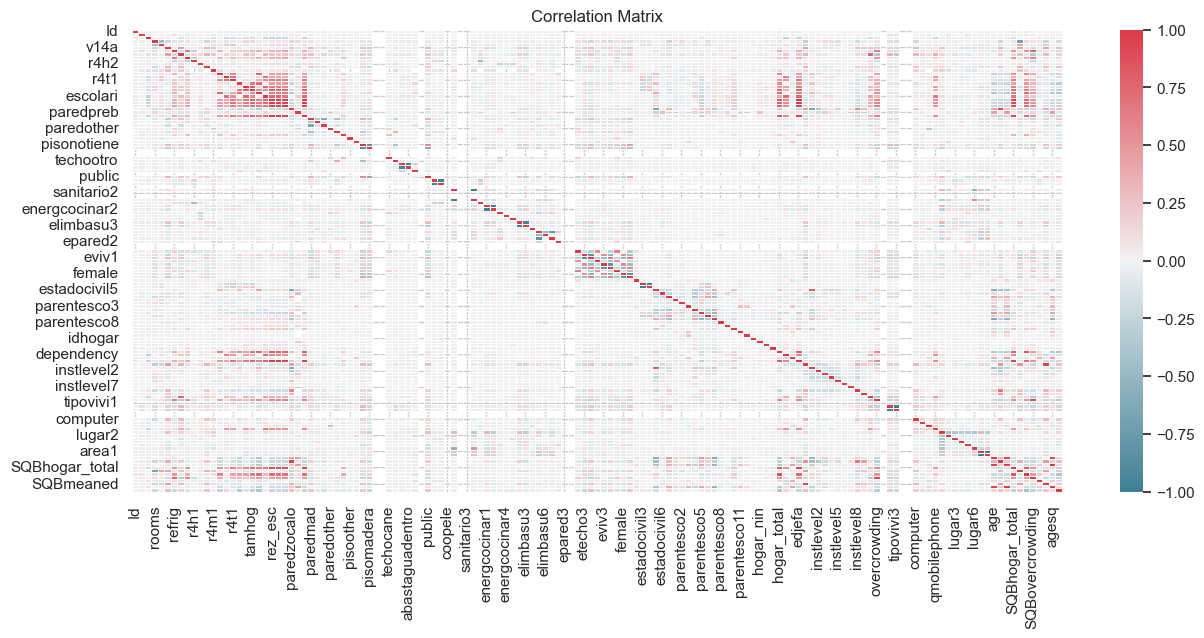

In [18]:
corr_mtx = df_encoded.corr()

plt.figure(figsize=(15, 6))
colormap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(corr_mtx, annot=False, cmap=colormap, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [19]:
X_train, y_train = df_encoded.drop(columns=["Target"]), df_encoded["Target"]

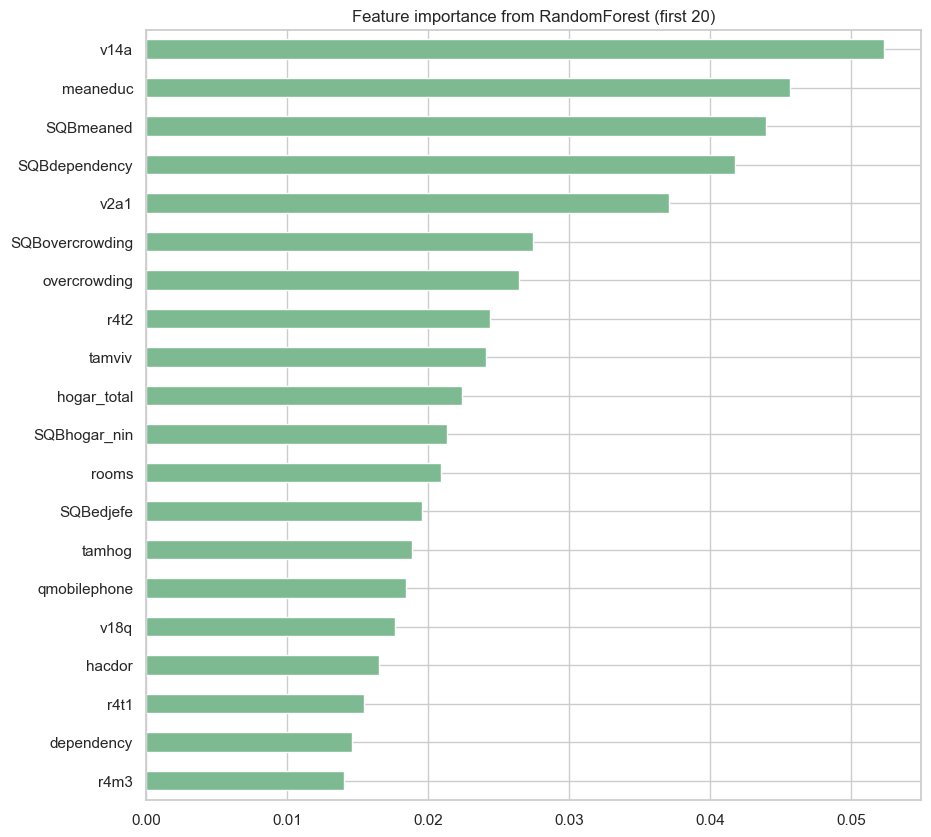

In [20]:
rf_clf = RandomForestClassifier(n_estimators = 500, max_depth=12, random_state=42)
rf_clf.fit(X_train, y_train)
rf_y_pred = rf_clf.predict(X_train)

pd.Series(
    rf_clf.feature_importances_, index = X_train.columns
).nlargest(20).plot(kind = 'barh', figsize = (10, 10), title = 'Feature importance from RandomForest (first 20)').invert_yaxis()